# **Table Content**:

>[Table Content:](#scrollTo=q8_6V_EqXuv9)

>>[Importing the libraries and mount Google Drive](#scrollTo=lw_4ecKjEG3F)

>>[Loading in the data](#scrollTo=yfV4kWQTD8PT)

>>>[Loading training & validation data: 0, 1, 1.5, 1.75, 2, 2.25 [mm]](#scrollTo=BxZu_4oGXPHk)

>>>[Loading testing data : 1.25 [mm]](#scrollTo=8BSq70e4Xg2G)

>>>[A preview of the first 10 rows of steadying data](#scrollTo=L-KeHfC2Y8uH)

>>>[A preview of the first 10 rows of pulsatile data](#scrollTo=7AD_j75eZERb)

>>[19 Neighbors (18+original)](#scrollTo=tCdaueUbYLD3)

>>>[Training and Validation Lists](#scrollTo=ifaS0kvPaXAq)

>>>[Testing Lists](#scrollTo=-8C8sxLKakGf)

>>[Preprocessing Data](#scrollTo=MPfXw6D6ZzSG)

>>>[Splitting the data into %80 training and %20 validation](#scrollTo=qmFBzrUoZ23l)

>>[Preparing Data and Generator](#scrollTo=9r4f-QIi3AMM)

>>[Designing the Model](#scrollTo=UVWVpZNC06U9)

>>>[Training the Model](#scrollTo=WXffhgfd1A9x)

>>[Prediction](#scrollTo=2Y_gXiVW3j4q)

>>>[Running Prediction](#scrollTo=qKShjhO11d1k)

>>[Points that close to the Wall](#scrollTo=cLn8cOboyBta)

>>[Distance to Wall](#scrollTo=1Tl0Ke6Ojl74)



## Importing the libraries and mount Google Drive

In [1]:
# Import all the necessary libraries
try:
  import pandas as pd
  import time
  import collections
  import plotly.graph_objects as go
  from google.colab import drive
  import glob
  import tensorflow as tf
  import scipy
  import dask.dataframe as dd
  from itertools import permutations, combinations
  from random import shuffle, choice
  import math
  import os
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.model_selection import train_test_split
  from tensorflow import keras
  from sklearn.metrics import r2_score
  from keras.models import Model
  from keras.layers import Input, Dense, TimeDistributed, Bidirectional, Reshape, Flatten
  from keras.layers.recurrent import LSTM
  from keras.layers.merge import concatenate
  from sklearn.metrics import mean_absolute_error
  from tensorflow.keras.models import load_model
  from pyCompare import blandAltman
  from sklearn.preprocessing import MinMaxScaler, StandardScaler
except:
  !pip install pyCompare

Using TensorFlow backend.


In [0]:
# This is to set up authority for uploading files from Google Drive, if training on regular PC, then no need!
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
# changing the directory to the right place in google
home_dir0 = '/content/gdrive/My Drive/Independent_Study_ML/'
home_dir1 = '/content/gdrive/My Drive/Colab_Notebooks/Independent_Study_ML/'

for dir in [home_dir0, home_dir1]:
  if os.path.exists(dir):
    home_dir = dir
    break

os.chdir(home_dir)

## Loading in the data

### Loading training & validation data: 0, 1, 1.5, 1.75, 2, 2.25 [mm]

In [0]:
steady = dd.read_csv('steady/*.csv').astype('float32')
pulsatile = dd.read_csv('pulsatile/*.csv').astype('float32')
steady = steady.drop(['Unnamed: 0','rho', 'wss'], axis=1).compute()
pulsatile = pulsatile.drop(['Unnamed: 0', 'rho', 'wss'], axis=1).compute()

# finding the average
steady['uavg'] = (steady['ux'] + steady['uy'] + steady['uz'])/3
pulsatile['uavg'] = (pulsatile['ux'] + pulsatile['uy'] + pulsatile['uz'])/3

### Loading testing data : 1.25 [mm]

In [0]:
test_steady = dd.read_csv('steady/testing/*.csv', header=None, names=['x', 'y', 'z', 'rho', 'ux', 'uy', 'uz', 'wss']).astype('float32')
test_pulsatile = dd.read_csv('pulsatile/testing/*.csv', header=None, names=['x', 'y', 'z', 'rho', 'ux', 'uy', 'uz', 'wss']).astype('float32')
test_steady = test_steady.drop(['rho', 'wss'], axis=1).compute()
test_pulsatile = test_pulsatile.drop(['rho', 'wss'], axis=1).compute()

# finding the average
test_steady['uavg'] = (test_steady['ux'] + test_steady['uy'] + test_steady['uz'])/3
test_pulsatile['uavg'] = (test_pulsatile['ux'] + test_pulsatile['uy'] + test_pulsatile['uz'])/3

### A preview of the first 10 rows of steadying data

In [0]:
steady.head(n=10)

,x,y,z,ux,uy,uz,uavg
0,9.9,0.352,1.05,0.00343,-5.550000e-17,0.000000,0.001143
1,9.8,0.352,1.05,0.00343,3.220000e-04,-0.000219,0.001178
2,9.7,0.352,1.05,0.00322,1.500000e-04,-0.000026,0.001115
3,9.6,0.352,1.05,0.00310,-3.160000e-05,-0.000017,0.001017
4,9.5,0.352,1.05,0.00323,-3.030000e-05,0.000015,0.001071
5,9.4,0.352,1.05,0.00324,-1.570000e-05,0.000015,0.001080
6,9.3,0.352,1.05,0.00328,-2.470000e-05,-0.000003,0.001084
7,9.2,0.352,1.05,0.00333,-2.250000e-05,0.000020,0.001109
8,9.1,0.352,1.05,0.00335,-3.300000e-05,0.000010,0.001109
9,9.0,0.352,1.05,0.00335,-7.530000e-06,0.000014,0.001119


In [0]:
test_steady.head(n=10)

,x,y,z,ux,uy,uz,uavg
0,9.9,0.140584,1.4375,0.004639,1.110223e-16,5.551115e-17,0.001546
1,9.8,0.140584,1.4375,0.004639,5.041233e-04,-4.023564e-04,0.001580
2,9.7,0.140584,1.4375,0.003396,3.656640e-04,2.372207e-04,0.001333
3,9.6,0.140584,1.4375,0.002317,2.546074e-04,-2.918775e-04,0.000760
4,9.5,0.140584,1.4375,0.002987,-2.049573e-04,3.704259e-05,0.000940
5,9.4,0.140584,1.4375,0.003027,1.052011e-04,1.343384e-05,0.001049
6,9.3,0.140584,1.4375,0.002849,-4.430748e-05,7.479115e-06,0.000938
7,9.2,0.140584,1.4375,0.002752,6.036137e-05,1.237768e-05,0.000942
8,9.1,0.140584,1.4375,0.002737,-1.181006e-04,3.298322e-05,0.000884
9,9.0,0.140584,1.4375,0.002766,3.480416e-05,1.108072e-05,0.000937


### A preview of the first 10 rows of pulsatile data

In [0]:
pulsatile.head(n=10)

,x,y,z,ux,uy,uz,uavg
0,9.9,0.352,1.05,0.001020,0.000000,0.000000,0.000340
1,9.8,0.352,1.05,0.001020,0.000097,-0.000066,0.000350
2,9.7,0.352,1.05,0.000961,0.000046,-0.000008,0.000333
3,9.6,0.352,1.05,0.000926,-0.000008,-0.000006,0.000304
4,9.5,0.352,1.05,0.000966,-0.000010,0.000004,0.000320
5,9.4,0.352,1.05,0.000970,-0.000005,0.000004,0.000323
6,9.3,0.352,1.05,0.000986,-0.000007,-0.000001,0.000326
7,9.2,0.352,1.05,0.001000,-0.000007,0.000005,0.000333
8,9.1,0.352,1.05,0.001010,-0.000010,0.000003,0.000334
9,9.0,0.352,1.05,0.001010,-0.000002,0.000004,0.000337


In [0]:
test_pulsatile.head(n=10)

,x,y,z,ux,uy,uz,uavg
0,9.9,0.140584,1.4375,0.019784,1.110223e-16,-5.551115e-17,0.006595
1,9.8,0.140584,1.4375,0.019784,2.103642e-03,-1.632373e-03,0.006752
2,9.7,0.140584,1.4375,0.013909,1.070989e-03,1.475503e-03,0.005485
3,9.6,0.140584,1.4375,0.009821,1.187658e-03,-1.623489e-03,0.003128
4,9.5,0.140584,1.4375,0.013284,-1.139426e-03,4.428843e-04,0.004196
5,9.4,0.140584,1.4375,0.013374,3.670564e-04,3.116483e-05,0.004591
6,9.3,0.140584,1.4375,0.012621,-4.281637e-04,2.693714e-04,0.004154
7,9.2,0.140584,1.4375,0.012219,2.339527e-04,-1.401723e-05,0.004146
8,9.1,0.140584,1.4375,0.012252,-6.667273e-04,2.974780e-04,0.003961
9,9.0,0.140584,1.4375,0.012389,1.430945e-04,-1.294183e-06,0.004177


## 19 Neighbors (18+original)

Showing below is an example of one neighborhood. There are 19 rows. Looking closely at x, y, z, they are close to each other among rows.

### Training and Validation Lists

In [0]:
tree_data = scipy.spatial.cKDTree(steady[['x', 'y','z']])
# these are the index of the nearest neighbors
steady_neighbors = tree_data.query(steady[['x', 'y','z']], k=19)[1] # 18 different indexes -> 19 points in total (because we already have the first one, original),  161 info in total because of 19*8 and add 1 to it because of the wall points info
steady_list = pd.DataFrame()
steady_list['neighbors'] = steady_neighbors.tolist()
steady.iloc[steady_neighbors[0][1:]]

,x,y,z,ux,uy,uz,uavg
13523,9.9,0.328700,1.0250,0.056573,0.000000e+00,-5.551115e-17,0.018858
25479,9.9,0.316817,1.0125,0.065451,0.000000e+00,0.000000e+00,0.021817
54389,9.9,0.393051,1.0875,0.070537,0.000000e+00,0.000000e+00,0.023512
40571,9.9,0.304934,1.0000,0.074438,0.000000e+00,0.000000e+00,0.024813
36455,9.9,0.304934,1.1000,0.070886,0.000000e+00,0.000000e+00,0.023629
54487,9.9,0.293051,1.0875,0.071462,0.000000e+00,0.000000e+00,0.023821
22049,9.9,0.316817,1.1125,0.061015,0.000000e+00,0.000000e+00,0.020338
40473,9.9,0.404934,1.0000,0.073234,0.000000e+00,0.000000e+00,0.024411
36357,9.9,0.404934,1.1000,0.069683,1.110223e-16,0.000000e+00,0.023228
59191,9.9,0.393051,0.9875,0.073248,0.000000e+00,0.000000e+00,0.024416


### Testing Lists

In [0]:
test_tree_data = scipy.spatial.cKDTree(test_steady[['x', 'y','z']])
# these are the index of the nearest neighbors
test_steady_neighbors = test_tree_data.query(test_steady[['x', 'y','z']], k=19)[1] # 18 different indexes -> 19 points in total (because we already have the first one, original),  161 info in total because of 19*8 and add 1 to it because of the wall points info
test_list = pd.DataFrame()
test_list['neighbors'] = test_steady_neighbors.tolist()
test_steady.iloc[test_steady_neighbors[0][1:]]

,x,y,z,ux,uy,uz,uavg
1,9.8,0.140584,1.4375,0.004639,5.041233e-04,-4.023564e-04,0.001580
98,9.9,0.040584,1.4375,0.007416,0.000000e+00,0.000000e+00,0.002472
686,9.9,0.140584,1.3375,0.013754,0.000000e+00,0.000000e+00,0.004585
99,9.8,0.040584,1.4375,0.007416,5.195832e-04,-6.060500e-05,0.002625
687,9.8,0.140584,1.3375,0.013754,3.124237e-04,-2.195966e-04,0.004616
588,9.9,0.240584,1.3375,0.009704,1.110223e-16,0.000000e+00,0.003235
784,9.9,0.040584,1.3375,0.017327,0.000000e+00,0.000000e+00,0.005776
589,9.8,0.240584,1.3375,0.009704,1.070609e-04,-1.173866e-04,0.003231
785,9.8,0.040584,1.3375,0.017327,-1.383348e-04,-5.425444e-04,0.005549
2,9.7,0.140584,1.4375,0.003396,3.656640e-04,2.372207e-04,0.001333


## Preprocessing Data

### Splitting the data into %80 training and %20 validation

In [0]:
training_list, validation_list = train_test_split(steady_list, test_size=0.2, random_state=0)

In [0]:
# stripping the index
training_list.reset_index(drop=True)
validation_list.reset_index(drop=True)
test_list.reset_index(drop=True)

,neighbors
0,"[0, 1, 98, 686, 99, 687, 588, 784, 589, 785, 2..."
1,"[1, 0, 99, 687, 2, 98, 686, 589, 785, 100, 688..."
2,"[2, 3, 100, 688, 1, 101, 689, 590, 786, 99, 68..."
3,"[3, 2, 101, 689, 4, 100, 688, 591, 787, 102, 6..."
4,"[4, 102, 690, 5, 3, 592, 788, 101, 103, 691, 6..."
...,...
63205,"[63205, 62029, 63204, 63107, 63206, 62028, 621..."
63206,"[63206, 62030, 63108, 63207, 63205, 61932, 621..."
63207,"[63207, 62031, 63109, 63206, 63208, 62030, 619..."
63208,"[63208, 62032, 63110, 63207, 63209, 61934, 620..."


## Preparing Data and Generator

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, steady, pulsatile, batch_size=32, dim=7, n_channels=19, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.steady = steady
        self.pulsatile = pulsatile
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

        # Generate data
        steady, pulsatile = self.__data_generation(list_IDs_temp)
        steady = (steady-np.mean(steady, axis=0))/np.std(steady, axis=0)
        pulsatile = (pulsatile-np.mean(pulsatile, axis=0))/np.std(pulsatile, axis=0)
        return steady, pulsatile

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        steady_df = np.empty((self.batch_size, self.n_channels, self.dim))
        pulsatile_df = np.empty((self.batch_size, self.n_channels, self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store steady
            tempt_steady = self.steady.iloc[ID.values.squeeze().tolist()]
            #tempt_steady = (tempt_steady-tempt_steady.mean())/tempt_steady.std()
            steady_df[i,] = tempt_steady

            # Store pulsatile
            tempt_pulsatile = self.pulsatile.iloc[ID.values.squeeze().tolist()]
            #tempt_pulsatile = (tempt_pulsatile-tempt_pulsatile.mean())/tempt_pulsatile.std()
            pulsatile_df[i,] = tempt_pulsatile
        return steady_df, pulsatile_df

## Designing the Model

In [0]:
# setting up a run name for logs reference
run_name = 'model_2_all'
use_bestWeight = True

# set a callback to save the best weight
filepath=os.path.join(run_name,"{epoch:02d}_val_mae:{val_mean_absolute_error:.4f}.hdf5")
callback = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# set up a callback to reduce the learning rate
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-15, verbose=1)

# early stop training if validation loss is not decreasing
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=4)

# set up a tensorboard logs
log_dir = f'./logs/{run_name}'

# creating the directories if not exists
for directory in [log_dir, run_name]:
  if not os.path.exists(directory):
    os.makedirs(directory)
# calling the generator
params = {'dim': (7),
          'batch_size': 220,
          'n_channels': 19,
          'shuffle': True}
test_params = {'dim': (7),
          'batch_size': 200,
          'n_channels': 19,
          'shuffle': False}
training_generator = DataGenerator(training_list, steady, pulsatile, **params)
validation_generator = DataGenerator(validation_list, steady, pulsatile, **params)
testing_generator = DataGenerator(test_list, test_steady, test_pulsatile, **test_params)

In [0]:
# create and fit the LSTM network
model_input = Input(shape=(19, 7,), name='input_layer')
model = Dense(500, kernel_initializer='normal', activation='relu')(model_input)
model = Dense(400, kernel_initializer='normal', activation='relu')(model)
model = Dense(300, kernel_initializer='normal', activation='relu')(model)
model = Dense(200, kernel_initializer='normal', activation='relu')(model)
model = Dense(100, kernel_initializer='normal', activation='relu')(model)

model = Dense(200, kernel_initializer='normal', activation='relu')(model)
model = Dense(300, kernel_initializer='normal', activation='relu')(model)
model = Dense(400, kernel_initializer='normal', activation='relu')(model)
model = Dense(500, kernel_initializer='normal', activation='relu')(model)

output_reshape = Dense(7, kernel_initializer='normal', activation='linear', name='output')(model)

model = Model(inputs=model_input, outputs=output_reshape)

model.summary()
# Open the file
with open(os.path.join(run_name, 'report.txt'), 'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 19, 7)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 500)           4000      
_________________________________________________________________
dense_2 (Dense)              (None, 19, 400)           200400    
_________________________________________________________________
dense_3 (Dense)              (None, 19, 300)           120300    
_________________________________________________________________
dense_4 (Dense)              (None, 19, 200)           60200     
_________________________________________________________________
dense_5 (Dense)              (None, 19, 100)           20100     
_________________________________________________________________
dense_6 (Dense)              (None, 19, 200)           2

### Training the Model

In [0]:
# loading the weight if training is already done, if not, then train
if use_bestWeight:
    filename = '24_val_mae:0.0669.hdf5'
    model = load_model(os.path.join(run_name, filename))
    #model.fit_generator(generator=training_generator, validation_data=validation_generator, use_multiprocessing=True, workers=2, epochs=40 , verbose=1, callbacks=[callback, reduce_lr, early_stop])

## Prediction

### Running Prediction

In [0]:
#model.evaluate_generator(testing_generator, workers=2, use_multiprocessing=True, verbose=1, callbacks=None)

In [0]:
test_predict=model.predict_generator(testing_generator, workers=2, use_multiprocessing=True, verbose=1, callbacks=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning:

invalid value encountered in true_divide



316/316 [==============================] - 38s 120ms/step


In [0]:
tempt_pulsatile = pulsatile.iloc[test_list.iloc[0].values.squeeze().tolist()]
tempt_pulsatile = (tempt_pulsatile-tempt_pulsatile.mean())/tempt_pulsatile.std()
tempt_pulsatile.iloc[0].to_numpy()

array([ 0.9131772 ,  0.82083696,  0.58167565, -0.8797969 , -0.05397564,
        0.38638294, -0.83537173], dtype=float32)

In [0]:
test_predict[0][0]

array([ 0.26203343, -0.01249467,  0.12004769,  0.0252616 , -0.06282833,
        0.08960003,  0.0240439 ], dtype=float32)

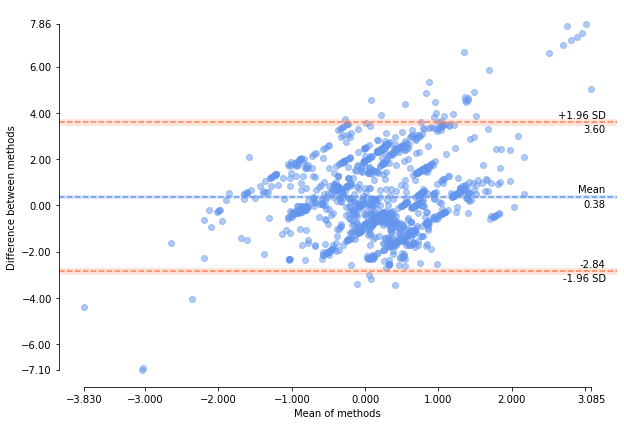

In [0]:
test_pred_df = []
test_true_df = []
for item in range(10):
  for idx in range(19):
    tempt_pulsatile = pulsatile.iloc[test_list.iloc[item].values.squeeze().tolist()]
    tempt_pulsatile = (tempt_pulsatile-tempt_pulsatile.mean())/tempt_pulsatile.std()
    if (np.isnan(test_predict[item][idx] - tempt_pulsatile.iloc[idx].to_numpy())).any():
      continue 
    test_true_df.extend(tempt_pulsatile.iloc[idx].to_numpy())
    test_pred_df.extend(test_predict[item][idx])
blandAltman(test_pred_df, test_true_df,savePath=os.path.join(run_name, 'BA_model1.png'),figureFormat='png')
blandAltman(test_pred_df, test_true_df)

In [0]:
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())
print('The dice score is', dice(test_pred_df, test_true_df),'.')

The dice score is 0.978494623655914 .


## Points that close to the Wall


Reading in the orignal dataset, steady dataset is sufficient since location of a point is the same between steady and pulsatile

In [0]:
steady_original = dd.read_csv('steady/0.0*.csv').astype('float32').compute()
print('There are', len(steady_original), 'datapoints.')

There are 38416 datapoints.


In [0]:
# wall classifcation: wall == 1 and wall ==0
# create a column called 
# magnitude of velocity = x^2 + y^2 + z^2
steady_original['velocity'] = np.sqrt(steady_original['ux'].pow(2)+steady_original['uy'].pow(2)+steady_original['uz'].pow(2))
steady_original['wall'] = np.where(steady_original['velocity']<=0.023, 'Yes', 'No')
# a preview of the first 5 rows of label data
steady_original["wall"].value_counts().rename_axis('Near Wall').to_frame('Counts')

,Counts
Near Wall,
No,28144
Yes,10272


In [0]:
pulsatile['velocity'] = np.sqrt(pulsatile['ux'].pow(2)+pulsatile['uy'].pow(2)+pulsatile['uz'].pow(2)) # learn adding conditions in dataframe
pulsatile['wall'] = np.where(pulsatile['velocity']<=0.00001, 1, 0)
# a preview of the first 5 rows of label data
pulsatile["wall"].value_counts()

0    691773
1       984
Name: wall, dtype: int64

## Distance to Wall


In [0]:
# Distance to Wall: r-sqrt(y^2+z^2)
radius_steady_y = (steady['y'].max()-steady['y'].min())/2 # radius is (max-min)/2
radius_steady_z = (steady['z'].max()-steady['z'].min())/2 # radius is (max-min)/2
if radius_steady_y == radius_steady_z:
  radius_steady = radius_steady_z
else:
  radius_steady = np.mean([radius_steady_y,radius_steady_z])
radius_pulsatile_y = (pulsatile['y'].max()-pulsatile['y'].min())/2 # radius is (max-min)/2
radius_pulsatile_z = (pulsatile['z'].max()-pulsatile['z'].min())/2 # radius is (max-min)/2
if radius_pulsatile_y == radius_pulsatile_z:
  radius_pulsatile = radius_pulsatile_z
else:
  radius_pulsatile = np.mean([radius_pulsatile_z,radius_pulsatile_y])
steady['Dis_to_Wall'] = radius_steady - np.sqrt(steady['y'].pow(2)+steady['z'].pow(2)) # 0.001 m is the radius
pulsatile['Dis_to_Wall'] = radius_pulsatile - np.sqrt(pulsatile['y'].pow(2)+pulsatile['z'].pow(2)) # 0.001 m is the radius

In [0]:
steady.head(n=200)

,x,y,z,ux,uy,uz,uavg,Dis_to_Wall
0,9.9,0.352,1.05,3.430000e-03,-5.550000e-17,0.000000e+00,1.143333e-03,1.542569
1,9.8,0.352,1.05,3.430000e-03,3.220000e-04,-2.190000e-04,1.177667e-03,1.542569
2,9.7,0.352,1.05,3.220000e-03,1.500000e-04,-2.570000e-05,1.114767e-03,1.542569
3,9.6,0.352,1.05,3.100000e-03,-3.160000e-05,-1.650000e-05,1.017300e-03,1.542569
4,9.5,0.352,1.05,3.230000e-03,-3.030000e-05,1.460000e-05,1.071433e-03,1.542569
...,...,...,...,...,...,...,...,...
195,0.2,0.252,1.05,5.550000e-17,0.000000e+00,0.000000e+00,1.850000e-17,1.570184
196,9.9,0.152,1.05,7.830000e-03,5.550000e-17,0.000000e+00,2.610000e-03,1.589055
197,9.8,0.152,1.05,7.830000e-03,-5.590000e-05,7.410000e-07,2.591613e-03,1.589055
198,9.7,0.152,1.05,7.900000e-03,1.070000e-04,8.700000e-05,2.698000e-03,1.589055


Text(0.5, 1.0, 'Steady Distance to Wall')

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



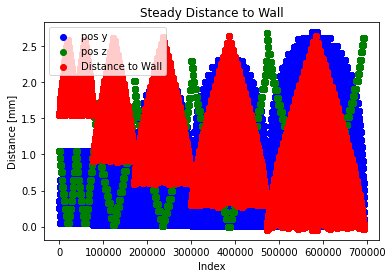

In [0]:
plt.scatter(range(0,len(steady['y'])), abs(steady['y']), c='blue')
plt.scatter(range(0,len(steady['z'])), abs(steady['z']), c='green')
plt.scatter(range(0,len(steady['Dis_to_Wall'])), steady['Dis_to_Wall'], c='red')
plt.legend(['pos y','pos z', 'Distance to Wall'])
plt.xlabel('Index')
plt.ylabel('Distance [mm]')
plt.title('Steady Distance to Wall')

Text(0.5, 1.0, 'Pulsatile Distance to Wall')

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



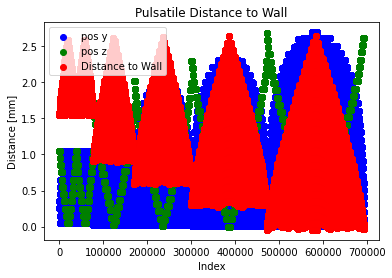

In [0]:
plt.scatter(range(0,len(pulsatile['y'])), abs(pulsatile['y']), c='blue')
plt.scatter(range(0,len(pulsatile['z'])), abs(pulsatile['z']), c='green')
plt.scatter(range(0,len(pulsatile['Dis_to_Wall'])), pulsatile['Dis_to_Wall'], c='red')
plt.legend(['pos y','pos z', 'Distance to Wall'])
plt.xlabel('Index')
plt.ylabel('Distance [mm]')
plt.title('Pulsatile Distance to Wall')


In [0]:
fig = go.Figure(data=[go.Mesh3d(x=steady['x'], y=steady['y'], z=steady['z'], color='lightpink', opacity=1.0)])
fig.show()